*italicized text*# Exploratory Analysis
[link text](https://)

# Explore

In [ ]:
#import libraries and view dataset
import numpy as np
import pandas as pd
from pandas import Series
from numpy.random import randn
import csv #csv library col-name
import scipy as sp
import matplotlib.pyplot as plt

#import data from google drive
from google.colab import drive
drive.mount('/content/drive')

# read charge, discharge, and impedance data for B0005 and create pandas dataframes for each
battery_data = pd.read_csv('/content/drive/MyDrive/BatteryProjectData/MyCleanedData/all_data.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Analyze the dataset
print(battery_data.head())  # Print the first few rows to understand the data structure

# Focus on specific attributes
attributes_of_interest = ['Voltage_measured', 'Current_measured', 'Temperature_measured', 'ambient_temperature', 'Time']

# Basic summary statistics
print(battery_data.describe())

   Voltage_measured  Current_measured  Temperature_measured  Current_charge  \
0          3.873017         -0.001201             24.655358           0.000   
1          3.479394         -4.030268             24.666480          -4.036   
2          4.000588          1.512731             24.675394           1.500   
3          4.012395          1.509063             24.693865           1.500   
4          4.019708          1.511318             24.705069           1.500   

   Voltage_charge    Time cycle_type  \
0           0.003   0.000     charge   
1           1.570   2.532     charge   
2           4.726   5.500     charge   
3           4.742   8.344     charge   
4           4.753  11.125     charge   

                                          start_time  ambient_temperature  \
0  [2.0080e+03 4.0000e+00 2.0000e+00 1.3000e+01 8...                   24   
1  [2.0080e+03 4.0000e+00 2.0000e+00 1.3000e+01 8...                   24   
2  [2.0080e+03 4.0000e+00 2.0000e+00 1.3000e+01 8... 

In [ ]:
# Fix the time offset such that each cycle begins when the previous one ends
# Detect when a new cycle starts (time resets to zero or a lower value than the end of the previous cycle)
battery_data['new_cycle'] = battery_data['Time'].diff() < 0

# Initiate a cumulative time shift that starts with zero
battery_data['time_shift'] = 0

# Loop through the data and apply the time shift for each new cycle
for i in range(1, len(battery_data)):
    if battery_data.loc[i, 'new_cycle']:
        battery_data.loc[i:, 'time_shift'] += battery_data.loc[i-1, 'Time']

# Apply the time shift
battery_data['Corrected_time'] = battery_data['Time'] + battery_data['time_shift']

In [ ]:
battery_data = battery_data.drop("new_cycle", axis='columns')
battery_data = battery_data.drop("time_shift", axis='columns')

print(battery_data.head())  # Print the first few rows to understand the data structure

   Voltage_measured  Current_measured  Temperature_measured  Current_charge  \
0          3.873017         -0.001201             24.655358           0.000   
1          3.479394         -4.030268             24.666480          -4.036   
2          4.000588          1.512731             24.675394           1.500   
3          4.012395          1.509063             24.693865           1.500   
4          4.019708          1.511318             24.705069           1.500   

   Voltage_charge    Time cycle_type  \
0           0.003   0.000     charge   
1           1.570   2.532     charge   
2           4.726   5.500     charge   
3           4.742   8.344     charge   
4           4.753  11.125     charge   

                                          start_time  ambient_temperature  \
0  [2.0080e+03 4.0000e+00 2.0000e+00 1.3000e+01 8...                   24   
1  [2.0080e+03 4.0000e+00 2.0000e+00 1.3000e+01 8...                   24   
2  [2.0080e+03 4.0000e+00 2.0000e+00 1.3000e+01 8... 

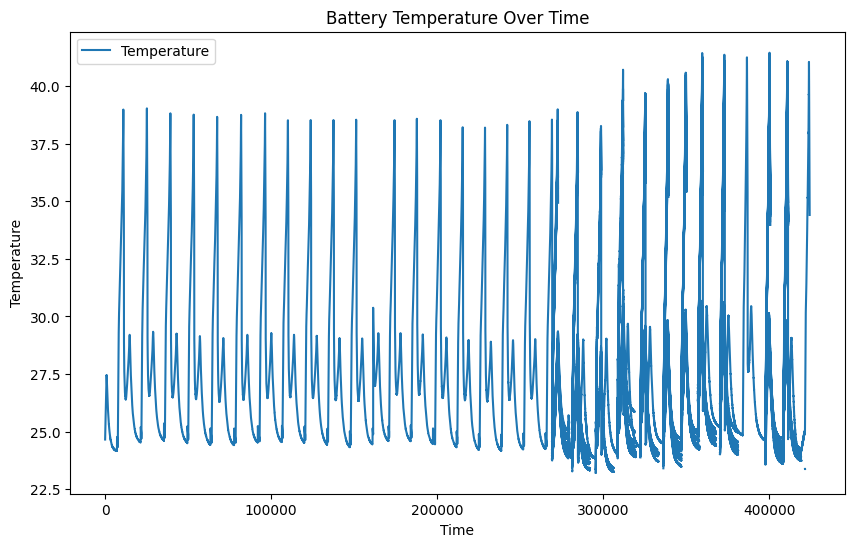

In [ ]:
# Plotting a simple static plot for initial visualization (replace 'time' with your actual time column if different)
plt.figure(figsize=(10, 6))
plt.plot(battery_data['Corrected_time'], battery_data['Temperature_measured'], label='Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Battery Temperature Over Time')
plt.legend()
plt.show()

In [ ]:
# Calculate necessary values for Heat Conduction
# Ensure 'Current_measured' is numeric
battery_data['Current_measured'] = pd.to_numeric(battery_data['Current_measured'], errors='coerce')

# Estimate initial impedance if necessary (using the average value of 200 milliohms)
estimated_initial_impedance = 0.2  # in ohms

# Assuming 'Battery_impedance' is a column with the impedance measurements
# If no impedance measurement is available, use the estimated initial impedance
battery_data['Battery_impedance'].fillna(estimated_initial_impedance, inplace=True)
battery_data['current_impedance'] = pd.to_numeric(battery_data['Battery_impedance'].ffill(), errors='coerce')

# Fill NaN values in 'Current_measured' if there are any after conversion
battery_data['Current_measured'].fillna(battery_data['Current_measured'].mean(), inplace=True)

# Calculate the change in temperature (ΔT) and the change in time (Δt)
battery_data['ΔT'] = battery_data['Temperature_measured'].diff().fillna(0)
battery_data['Δt'] = battery_data['Corrected_time'].diff().fillna(battery_data['Corrected_time'].iloc[1])

# Compute the temperature gradient over time
battery_data['temp_gradient'] = battery_data['ΔT'] / battery_data['Δt']

# Compute the heat generated using the dynamic impedance and the measured current
battery_data['Heat_generated'] = battery_data['Current_measured'] ** 2 * battery_data['current_impedance'] * battery_data['Δt']

# For an 18650 cylindrical battery, the surface area can be approximated using the dimensions of the battery:
# A = 2 * pi * radius * height
A = 0.0042

# Calculate the heat flux using Fourier's Law: q = -k * ∇T
# Placeholder for thermal conductivity 'k'
k = 0.43 # W/mK, placeholder value for thermal conductivity
battery_data['heat_flux'] = -k * battery_data['temp_gradient']

# we can calculate the overall heat loss rate (power) assuming the battery's surface is the area of heat dissipation.
# This will be an approximation, assuming that the entire battery surface is at the temperature measured by the sensor.
battery_data['heat_loss_rate'] = -k * battery_data['temp_gradient'] * A

# Display the new computed features
print(battery_data[['Corrected_time', 'Temperature_measured', 'ΔT', 'Δt', 'temp_gradient', 'current_impedance', 'Heat_generated', 'heat_flux', 'heat_loss_rate']].head())

   Corrected_time  Temperature_measured        ΔT     Δt  temp_gradient  \
0           0.000             24.655358  0.000000  2.532       0.000000   
1           2.532             24.666480  0.011122  2.532       0.004393   
2           5.500             24.675394  0.008915  2.968       0.003004   
3           8.344             24.693865  0.018471  2.844       0.006495   
4          11.125             24.705069  0.011204  2.781       0.004029   

   current_impedance  Heat_generated  heat_flux  heat_loss_rate  
0                0.2    7.300192e-07  -0.000000       -0.000000  
1                0.2    8.225488e+00  -0.001889       -0.000008  
2                0.2    1.358367e+00  -0.001292       -0.000005  
3                0.2    1.295312e+00  -0.002793       -0.000012  
4                0.2    1.270407e+00  -0.001732       -0.000007  


In [ ]:
# Calculate the heat transfer rate due to convection

# Constants for air at room temperature
g = 9.81  # m/s^2, acceleration due to gravity
nu_air = 15.89e-6  # m^2/s, kinematic viscosity of air
alpha_air = 22.5e-6  # m^2/s, thermal diffusivity of air
k_air = 0.0257  # W/(m·K), thermal conductivity of air
T_ambient_kelvin = 273.15 + battery_data['ambient_temperature']  # Convert to Kelvin for beta calculation

# Empirical constants for Nusselt number correlation, assuming laminar flow over a vertical plate
C = 0.59  # Empirical constant, varies depending on the situation - Natural Flow
n = 0.25  # Empirical constant for laminar flow

# Characteristic length for Grashof number, using battery height
L = 0.065  # m, height of a standard 18650 battery

# Calculate Grashof and Prandtl numbers
Gr = (g * (1/T_ambient_kelvin) * (battery_data['Temperature_measured'] - battery_data['ambient_temperature']) * L**3) / nu_air**2
Pr = nu_air / alpha_air

# Calculate Nusselt number
Nu = C * (Gr * Pr)**n

# Calculate convective heat transfer coefficient 'h' using Nusselt number
h = (Nu * k_air) / L

# Calculate convective heat transfer rate
battery_data['convective_heat_transfer'] = h * (battery_data['Temperature_measured'] - battery_data['ambient_temperature']) * A

# Display the new computed heat transfer rate due to convection
print(battery_data[['Corrected_time', 'Temperature_measured', 'ambient_temperature', 'convective_heat_transfer']].head())
battery_data.to_csv('/content/drive/MyDrive/BatteryProjectData/MyCleanedData/all_data_fixed.csv', index=False)

   Corrected_time  Temperature_measured  ambient_temperature  \
0           0.000             24.655358                   24   
1           2.532             24.666480                   24   
2           5.500             24.675394                   24   
3           8.344             24.693865                   24   
4          11.125             24.705069                   24   

   convective_heat_transfer  
0                  0.007290  
1                  0.007445  
2                  0.007570  
3                  0.007830  
4                  0.007988  


# Model

# Simulation